In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller 
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
from pmdarima import auto_arima




In [29]:
df=pd.read_csv('Erathna_project.csv')
df.head()



,Year,Month,Rainfall,Temp_min,Temp_max,Hum_min,Hum_max
0,2010,January,130.2,22.1,32.1,NaN,NaN
1,2010,February,41.3,22.6,33.9,NaN,NaN
2,2010,March,171.5,23.1,35.2,NaN,NaN
3,2010,April,421.7,23.7,33.5,NaN,NaN
4,2010,May,793.3,24.0,31.8,NaN,NaN


In [30]:
df["Time"]=df["Year"].astype(str)+"-"+df["Month"].astype(str)



In [31]:
df.head()



,Year,Month,Rainfall,Temp_min,Temp_max,Hum_min,Hum_max,Time
0,2010,January,130.2,22.1,32.1,NaN,NaN,2010-January
1,2010,February,41.3,22.6,33.9,NaN,NaN,2010-February
2,2010,March,171.5,23.1,35.2,NaN,NaN,2010-March
3,2010,April,421.7,23.7,33.5,NaN,NaN,2010-April
4,2010,May,793.3,24.0,31.8,NaN,NaN,2010-May


In [32]:
hum_min=df[["Time","Hum_min"]]
hum_min.head()



,Time,Hum_min
0,2010-January,NaN
1,2010-February,NaN
2,2010-March,NaN
3,2010-April,NaN
4,2010-May,NaN


In [33]:
hum_min['Time']=pd.to_datetime(hum_min['Time'])


C:\Users\wasan\AppData\Local\Temp/ipykernel_13440/3648415634.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hum_min['Time']=pd.to_datetime(hum_min['Time'])


In [34]:
hum_min.head()



,Time,Hum_min
0,2010-01-01,NaN
1,2010-02-01,NaN
2,2010-03-01,NaN
3,2010-04-01,NaN
4,2010-05-01,NaN


In [35]:
#Checking for missing values
hum_min.isna().sum()





Time        0
Hum_min    14
dtype: int64

In [36]:
#Setting the time index
hum_min.set_index('Time',inplace=True)

In [37]:
hum_min=hum_min.resample('MS').first()

In [38]:
#filling missing values
hum=hum_min.fillna(method="bfill")
hum.head()



,Hum_min
Time,
2010-01-01,79.3
2010-02-01,79.3
2010-03-01,79.3
2010-04-01,79.3
2010-05-01,79.3


In [39]:
hum = hum.rename(columns = {'Hum_min': 'Humidity'})
hum.head()



,Humidity
Time,
2010-01-01,79.3
2010-02-01,79.3
2010-03-01,79.3
2010-04-01,79.3
2010-05-01,79.3


In [40]:
hum.columns



Index(['Humidity'], dtype='object')

<AxesSubplot:xlabel='Time'>

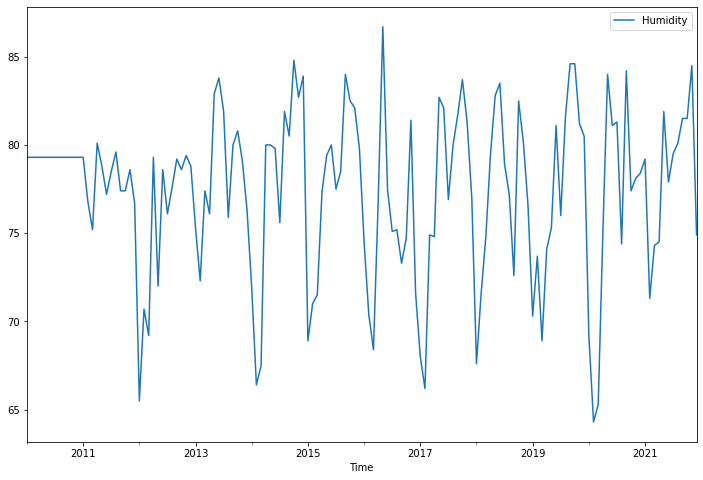

In [41]:
hum.plot(figsize=(12,8))



No trend. But some evidence for seasonality

# Testing For Stationarity

In [42]:
### ADF Test
test_result=adfuller(hum['Humidity'])
#Ho: The series is non stationary
#H1: The series is stationary

def adfuller_test(x):
    result=adfuller(x)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    
adfuller_test(hum['Humidity'])



ADF Test Statistic : -3.5747927583210197
p-value : 0.006261630398394748
#Lags Used : 13
Number of Observations Used : 130
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [43]:
# KPSS test
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(hum['Humidity'])


KPSS Statistic: 0.07179716170946852
p-value: 0.1
num lags: 14
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [44]:
#PhillipsPerron Test
from arch.unitroot import PhillipsPerron

pp = PhillipsPerron(hum['Humidity'].astype(float))
print(pp.summary().as_text())


     Phillips-Perron Test (Z-tau)    
Test Statistic                 -5.948
P-value                         0.000
Lags                               14
-------------------------------------

Trend: Constant
Critical Values: -3.48 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


# ACF and PACF plots

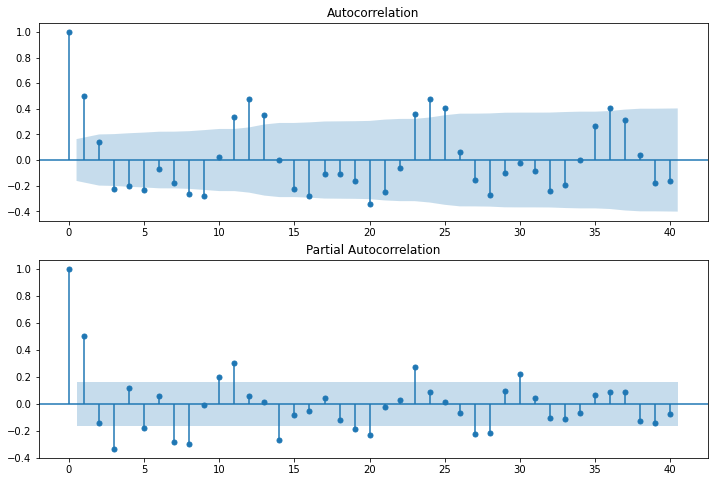

In [45]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(hum['Humidity'],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(hum['Humidity'],lags=40,ax=ax2)


According to the PACF and ACF plots it's better to start with p=3, d=0, q=5

In [50]:
arima_model=auto_arima(hum['Humidity'].astype(float),start_p=0,start_d=0,start_q=0,max_p=3,max_D=1,max_q=5,start_P=0,start_D=0,start_Q=0,max_P=3,max_Q=5,m=12,seasonal=True,error_action='warn',trace=True,supress_warnings=True,stepwise=False,random_state=20,n_fits=80,maxiter=70)


 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=856.908, Time=0.02 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=837.254, Time=0.10 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=821.467, Time=0.22 sec
 ARIMA(0,0,0)(0,0,3)[12] intercept   : AIC=818.162, Time=0.53 sec
 ARIMA(0,0,0)(0,0,4)[12] intercept   : AIC=815.688, Time=1.15 sec
 ARIMA(0,0,0)(0,0,5)[12] intercept   : AIC=inf, Time=7.29 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=821.686, Time=0.46 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=798.188, Time=0.62 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=822.427, Time=1.41 sec
 ARIMA(0,0,0)(1,0,3)[12] intercept   : AIC=812.700, Time=3.11 sec
 ARIMA(0,0,0)(1,0,4)[12] intercept   : AIC=inf, Time=5.71 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=809.670, Time=1.21 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=799.715, Time=1.17 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=825.819, Time=1.65 sec
 ARIMA(0,0,0)(2,0,3)[12] intercept   : AIC=inf, Time=3.24 sec
 ARIMA(0,0,0)(3,0,0)[1

# Forecast Humidity using the model

In [51]:
model=sm.tsa.statespace.SARIMAX(hum["Humidity"].astype('float'),order=(1, 0, 2),seasonal_order=(2,0,0,12))
results=model.fit()
results.summary()


C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                            Humidity   No. Observations:                  144
Model:             SARIMAX(1, 0, 2)x(2, 0, [], 12)   Log Likelihood                -400.087
Date:                             Tue, 26 Apr 2022   AIC                            812.173
Time:                                     01:36:15   BIC                            829.992
Sample:                                 01-01-2010   HQIC                           819.414
                                      - 12-01-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   8.43e-05   1.19e+04      0.000       1.000       1.000
ma.L1         -0.7515      0.085     -8.871      0.000      -0.918      -0.585
ma.L2         -0.2025      0.089     -2.272      0.023      -0.377      -0.028
ar.S.L12       0.2962      0.082      3.596      0.000       0.135       0.458
ar.S.L24       0.3284      0.102      3.224      0.001       0.129       0.528
sigma2        14.2837      1.604      8.902      0.000      11.139      17.428
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 5.26
Prob(Q):                              0.78   Prob(JB):                         0.07
Heteroskedasticity (H):               1.47   Skew:                            -0.42
Prob(H) (two-sided):                  0.19   Kurtosis:                         3.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [62]:
beg_dt='2019-01-01'
end_dt='2025-12-01'

In [ ]:
#results.predict(start=beg_dt,end=end_dt,dynamic=True)

C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<AxesSubplot:xlabel='Time'>

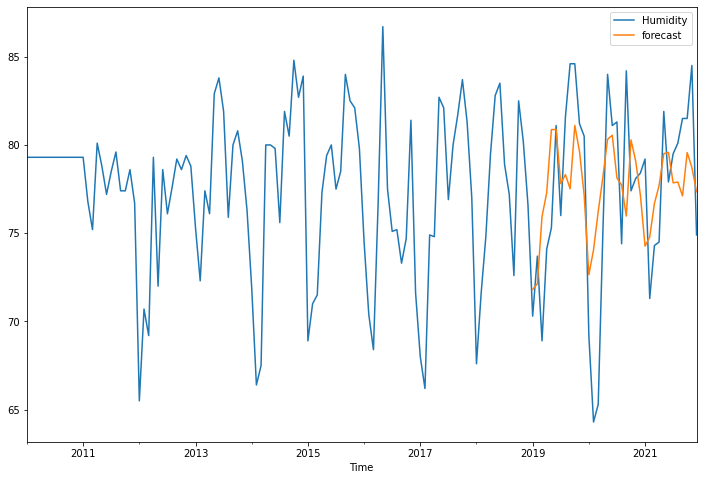

In [63]:
hum['forecast']=results.predict(start=beg_dt,end=end_dt,dynamic=True)
hum[['Humidity','forecast']].plot(figsize=(12,8))


In [22]:
hum.tail()


,Humidity,forecast
Time,,
2021-08-01,80.1,77.691697
2021-09-01,81.5,78.335139
2021-10-01,81.5,79.993474
2021-11-01,84.5,80.437567
2021-12-01,74.9,80.518883
